# Idealized Dipole: Control Group
Provide a control set AR for an idealized AR geometry. Each loop will be heated by a 200 s nanoflare pulse, beginning at $t=0$ s. Essentially, we are just letting an AR cool by letting each loop be heated and cool simultaneously.

In [2]:
import os
import subprocess
import logging
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sunpy.map
import astropy.units as u

import synthesizAR
from synthesizAR.model_ext import EbtelInterface,UniformHeating

%matplotlib inline

## Field Configuration

In [4]:
zshape=100
zrange=u.Quantity([0,300]*u.arcsec)

In [5]:
field = synthesizAR.Skeleton(hmi_fits_file='/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole/synthetic_hmi_map.fits',
                             resample=u.Quantity([100,100]*u.pixel))

In [6]:
field.extrapolate_field(zshape,zrange)

True


yt : [INFO     ] 2017-04-04 23:00:21,377 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-04-04 23:00:21,378 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-04-04 23:00:21,380 Parameters: domain_left_edge          = [ -1.02667285e+10  -1.02667285e+10   4.33805429e+08]
yt : [INFO     ] 2017-04-04 23:00:21,381 Parameters: domain_right_edge         = [  1.07728348e+10   1.07728348e+10   2.12564660e+10]
yt : [INFO     ] 2017-04-04 23:00:21,382 Parameters: cosmological_simulation   = 0.0


In [7]:
field.extract_streamlines(500,loop_length_range=[1e9,1e11]*u.cm)

yt : [INFO     ] 2017-04-04 23:01:05,087 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 500/500 [00:01<00:00, 360.81it/s]
yt : [INFO     ] 2017-04-04 23:01:07,267 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 95/95 [00:00<00:00, 321.53it/s]
yt : [INFO     ] 2017-04-04 23:01:07,958 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 24/24 [00:00<00:00, 274.14it/s]
yt : [INFO     ] 2017-04-04 23:01:08,393 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 7/7 [00:00<00:00, 200.74it/s]
yt : [INFO     ] 2017-04-04 23:01:08,726 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 1/1 [00:00<00:00, 50.05it/s]


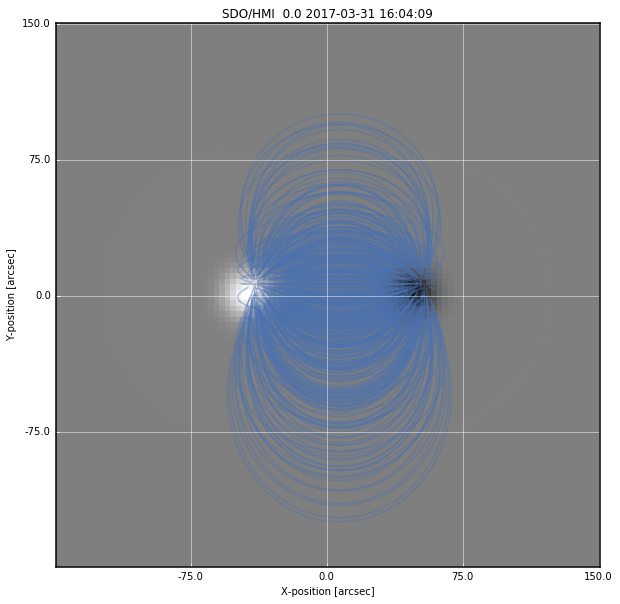

In [8]:
field.peek(alpha=0.4)

In [9]:
field.make_loops()

(array([ 124.,   99.,   76.,   58.,   36.,   30.,   23.,   25.,    9.,   20.]),
 array([  3.36152373e+09,   5.10748746e+09,   6.85345119e+09,
          8.59941492e+09,   1.03453786e+10,   1.20913424e+10,
          1.38373061e+10,   1.55832698e+10,   1.73292336e+10,
          1.90751973e+10,   2.08211610e+10]),
 <a list of 10 Patch objects>)

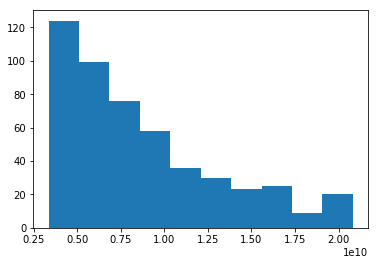

In [10]:
plt.hist([l.full_length.value for l in field.loops])

## Loop Simulations

Now, configure loop simulations. We'll use a single heating pulse at $t=0$ s for each loop and let the heating rate be determined by local field strength.

In [11]:
heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'stress_level':0.1,
    'average_waiting_time':4800.0,
}

In [12]:
heating_model = UniformHeating(heating_options)

In [13]:
ih = synthesizAR.util.InputHandler(os.path.join('/home/wtb2/Documents/codes',
                                                'ebtelPlusPlus/config/ebtel.example.cfg.xml'))
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['adaptive_solver_error'] = 1e-6
base_config['adaptive_solver_safety'] = 0.5
base_config['total_time'] = 5000.0
base_config['use_flux_limiting'] = True
base_config['heating']['background'] = 1e-6
base_config['heating']['partition'] = 1.0

In [14]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                            '/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole_control/hydro_config/',
                            '/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole_control/hydro_results/')

In [15]:
field.configure_loop_simulations(ebtel_interface)

And run them.

In [16]:
for loop in field.loops:
    subprocess.call([os.path.join('/home/wtb2/Documents/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

Load the results and save the field.

In [17]:
field.load_loop_simulations(
    ebtel_interface,
    savefile='/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole_control/loop_parameters.h5'
                           )

In [19]:
field.save(savedir='/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole_control/field_checkpoint')

(0, 5000.0)

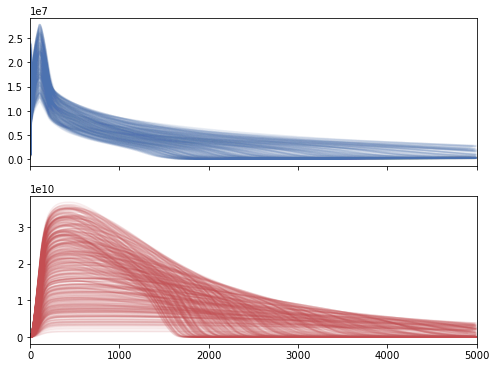

In [21]:
fig,axes = plt.subplots(2,1,figsize=(8,6),sharex=True)
for loop in field.loops:
    axes[0].plot(loop.time,loop.temperature[:,0],
                 color=sns.color_palette('deep')[0],
                 alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0],
                 color=sns.color_palette('deep')[2],
                 alpha=0.1)
axes[0].set_xlim([0,5e3])